# <font color = 'pickle'>**Handling Long Sequence- Chunking** </font>

# <font color = 'pickle'>**Binary Classification - Sentiment Analysis with the IMDB Dataset** </font>







## Outline
1. **Setting up the Environment**: Installing necessary libraries and setting up paths.
2. **Exploring and Understanding IMDB Dataset**: Understanding the structure and content of the dataset.

3. **Data Preprocessing**: Techniques to prepare the data for training, including handling different data splits and tokenization
4. **Training the Model**: Feeding data and adjusting weights.
5. **Inference**: Evaluate model on test set and making predictions.



# <font color = 'pickle'> **Setting up the Environment** </font>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import sys
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount("/content/drive")
    !pip install datasets transformers evaluate wandb accelerate -U -qq
    base_folder = Path("/content/drive/MyDrive/data")

else:
    base_folder = Path("/home/harpreet/Insync/google_drive_shaannoor/data")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
custom_function_folder = base_folder/'custom-functions/fall_2023/'


In [4]:
sys.path

['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/root/.ipython']

In [5]:
sys.path.append(str(custom_function_folder))

In [6]:
sys.path

['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive/data/custom-functions/fall_2023']

In [7]:
%matplotlib inline
from datasets import load_dataset, DatasetDict
from transformers import AutoConfig
from transformers import AutoModelForSequenceClassification
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
import evaluate
import numpy as np
from scipy.special import softmax
from scipy.special import logsumexp
from transformers import Trainer
import torch
import torch.nn as nn

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial

from functions_sliding_window_longer_seq import collate_function, aggregate_predictions, CustomTrainer, evaluate_model, free_memory

# <font color = 'pickle'> **Exploring and Understanding Dataset**

## <font color = 'pickle'> **Load Data set**
    


In [8]:
imdb_dataset = load_dataset("imdb")

# <font color = 'pickle'> **Data Pre-processing**</font>

## <font color = 'pickle'> **Filtering Larger Reviews**</font>

In [9]:
# Filter samples with more than 400 words
def filter_long_samples(example):
    return len(example['text'].split()) > 400

imdb_dataset_long = imdb_dataset.filter(filter_long_samples)

### <font color = 'pickle'> **Extract Splits**

In [10]:
train_split = imdb_dataset_long['train']
test_validation_dataset = imdb_dataset_long["test"]

### <font color = 'pickle'> **Create futher subdivions of the splits** </font>

In [11]:
# Split the test set into test and validation sets
test_val_splits = imdb_dataset_long["test"].train_test_split(
    test_size=0.4, seed=42)  # 60% for validation, 40% for test

# Extract the test and validation splits
valid_split = test_val_splits["train"]
test_split = test_val_splits["test"]


### <font color = 'pickle'> **Create subset for experimentation** </font>

In [12]:
train_split_small = train_split.shuffle(seed=42).select(range(10))
val_split_small = valid_split.shuffle(seed=42).select(range(10))
test_split_small = test_split.shuffle(seed=42).select(range(10))


### <font color = 'pickle'> **Combine splits**</font>



In [13]:
train_val = DatasetDict(
    {"train": train_split, "valid": valid_split})
train_val_small = DatasetDict(
    {"train": train_split_small, "valid": val_split_small})


In [14]:
train_val

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 3353
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 1878
    })
})

In [15]:
train_val_small

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 10
    })
})

#  <font color = 'pickle'> **Model Training**

## <font color = 'pickle'> **Set up Logger for experiments**</font>

In [16]:
import wandb
# setup wandb
wandb.login()  # you will need to craete wandb account first
# Set project name for logging
%env WANDB_PROJECT = nlp_course_fall_2023-sentiment-analysis-long-seq

wandb: Currently logged in as: hsingh-utd. Use `wandb login --relogin` to force relogin


env: WANDB_PROJECT=nlp_course_fall_2023-sentiment-analysis-long-seq


## <font color = 'pickle'> **Hyperparameters and Checkpointing**</font>

In [17]:
from transformers import TrainingArguments

# Define the directory where model checkpoints will be saved
model_folder = base_folder / "models"/"nlp_fall_2023/imdb/long"
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=1,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=16,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=1,
    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=2e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,
    fp16= True, # Use mixed precision training for memroy optimization
    # argument for EvalPred to include inputs and outputs
    remove_unused_columns=False,


    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 20 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 20 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints

    # Use 'accuracy' as the metric to determine the best model
    # metric_for_best_model="accuracy",
    # greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name='imdb_long_seq_chunk_avg_log',  # Experiment name for Weights & Biases
)


##  <font color = 'pickle'> **Initialize Trainer**</font>

In [18]:
checkpoint = "distilbert-base-uncased"
config = AutoConfig.from_pretrained(checkpoint)
class_names = train_val['train'].features['label'].names

id2label = {}
for id_, label_ in enumerate(class_names):
    id2label[str(id_)] = label_

label2id = {}
for id_, label_ in enumerate(class_names):
    label2id[label_] = id_

config.id2label = id2label
config.label2id = label2id

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, config = config)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
collate_fn = partial(collate_function, tokenizer=tokenizer,max_length = 512, stride = 100)
trainer = CustomTrainer(
    loss_type = "average_log_probs",
    # loss_type = "average_probs",
    # loss_type = "max",
    # loss_type = "loss_per_chunk",
    model=model,
    args=training_args,
    train_dataset=train_val["train"],
    eval_dataset=train_val["valid"],
    data_collator=collate_fn,
    tokenizer=tokenizer,

)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
# model.config

##  <font color = 'pickle'> **Start Training**

In [20]:
trainer.train() # start training


Step,Training Loss,Validation Loss
20,0.655200,0.625813
40,0.602500,0.499649
60,0.523100,0.436693
80,0.435500,0.396040
100,0.326000,0.367421
120,0.369500,0.367882
140,0.350900,0.379377
160,0.363300,0.342378
180,0.308200,0.347021
200,0.385000,0.360069


TrainOutput(global_step=210, training_loss=0.42640286400204613, metrics={'train_runtime': 114.1255, 'train_samples_per_second': 29.38, 'train_steps_per_second': 1.84, 'total_flos': 1007547034177536.0, 'train_loss': 0.42640286400204613, 'epoch': 1.0})

In [21]:
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")

The best model was saved at step 160.


## <font color = 'pickle'> **Evaluation**


### <font color = 'pickle'> **Check performance on validation set**</font>


In [22]:
# trainer.model.config

In [23]:
path = 'checkpoint-' + str(best_model_checkpoint_step)
checkpoint = str(model_folder/path)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

In [24]:
# model.config

In [25]:
free_memory()
train_accuracy = evaluate_model(trainer.get_test_dataloader(train_val['train']), model, metric_only=True)
train_accuracy

0.9179838950193856

In [26]:
free_memory()
val_accuracy, val_predictions, val_labels = evaluate_model(trainer.get_test_dataloader(train_val['valid']), model, metric_only=False)
val_accuracy

0.8924387646432375

In [27]:
val_predictions[0:10]

[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]

In [28]:
val_labels[0:10]

[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]

In [29]:
free_memory()
aggregation_method = "majority_vote"

val_accuracy = evaluate_model(trainer.get_test_dataloader(train_val['train']),
                                                           model, metric_only=True,aggregation_method=aggregation_method)
print(val_accuracy)

0.8941246644795705


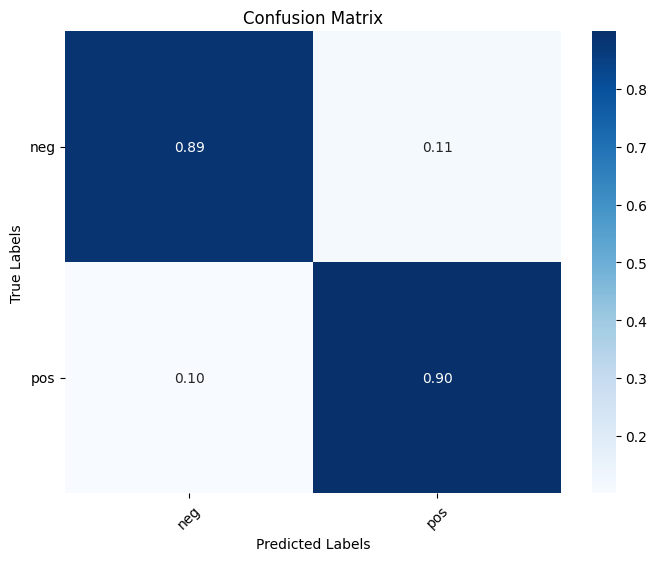

In [30]:
#  Generate the confusion matrix
cm = confusion_matrix(val_labels, val_predictions,normalize='true')

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
ax= sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
# Ensure x-labels are vertical
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Ensure y-labels are horizontal
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [31]:
# log the Confusion Matrix to Wandb
wandb.log({"conf_mat": wandb.plot.confusion_matrix(
    preds=val_predictions, y_true=val_labels,
    class_names=['neg', 'pos'])})


In [32]:
wandb.finish()


eval/loss,█▅▃▂▂▂▂▁▁▁
eval/runtime,▆█▄▃▆▁▁▅▆▄
eval/samples_per_second,▃▁▅▆▃██▄▃▅
eval/steps_per_second,▃▁▅▆▃██▄▃▅
train/epoch,▁▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇███
train/global_step,▁▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇████
train/learning_rate,█▇▆▆▅▄▃▃▂▁
train/loss,█▇▅▄▁▂▂▂▁▃
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


### <font color = 'pickle'> **Check the best saved model**</font>


In [33]:
# After training, let us check the best checkpoint
# We need this for Predioctions and Evaluations
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")


The best model was saved at step 160.


#  <font color = 'pickle'> **Inference**

## <font color = 'pickle'> **Test Set Evaluation**


In [34]:
path = 'checkpoint-' + str(best_model_checkpoint_step)
checkpoint = str(model_folder/path)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)


In [35]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
collate_fn = partial(collate_function, tokenizer = tokenizer, max_length =512, stride=100)
test_laoder = DataLoader(test_split, batch_size=16, collate_fn=collate_fn)

In [36]:
for x in test_laoder:
    print(x['input_ids'].shape)
    print(x['labels'].shape)
    print(x['doc_labels'].shape)
    print(x.keys())
    print(x['overflow_to_sample_mapping'])
    break


torch.Size([36, 512])
torch.Size([36])
torch.Size([16])
dict_keys(['input_ids', 'attention_mask', 'overflow_to_sample_mapping', 'labels', 'doc_labels'])
tensor([ 0,  0,  1,  1,  2,  2,  3,  3,  3,  4,  4,  5,  5,  6,  7,  7,  8,  8,
         9,  9, 10, 10, 10, 11, 11, 11, 11, 12, 12, 13, 13, 14, 14, 14, 15, 15])


In [37]:
free_memory
test_accuracy = evaluate_model(test_laoder, model)


In [38]:
test_accuracy

0.9098164405426975